# Text Analysis with (MBTI) Myers-Briggs Personality Type Dataset

In [43]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# read data
data = pd.read_csv('mbti_1.csv') # dtype = {'type': str,'post': ,

## Overview of the data

In [44]:
data.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [45]:
### One post

In [46]:
data.head(1).posts.values

array([ "'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design

# Distribution of the target variable?

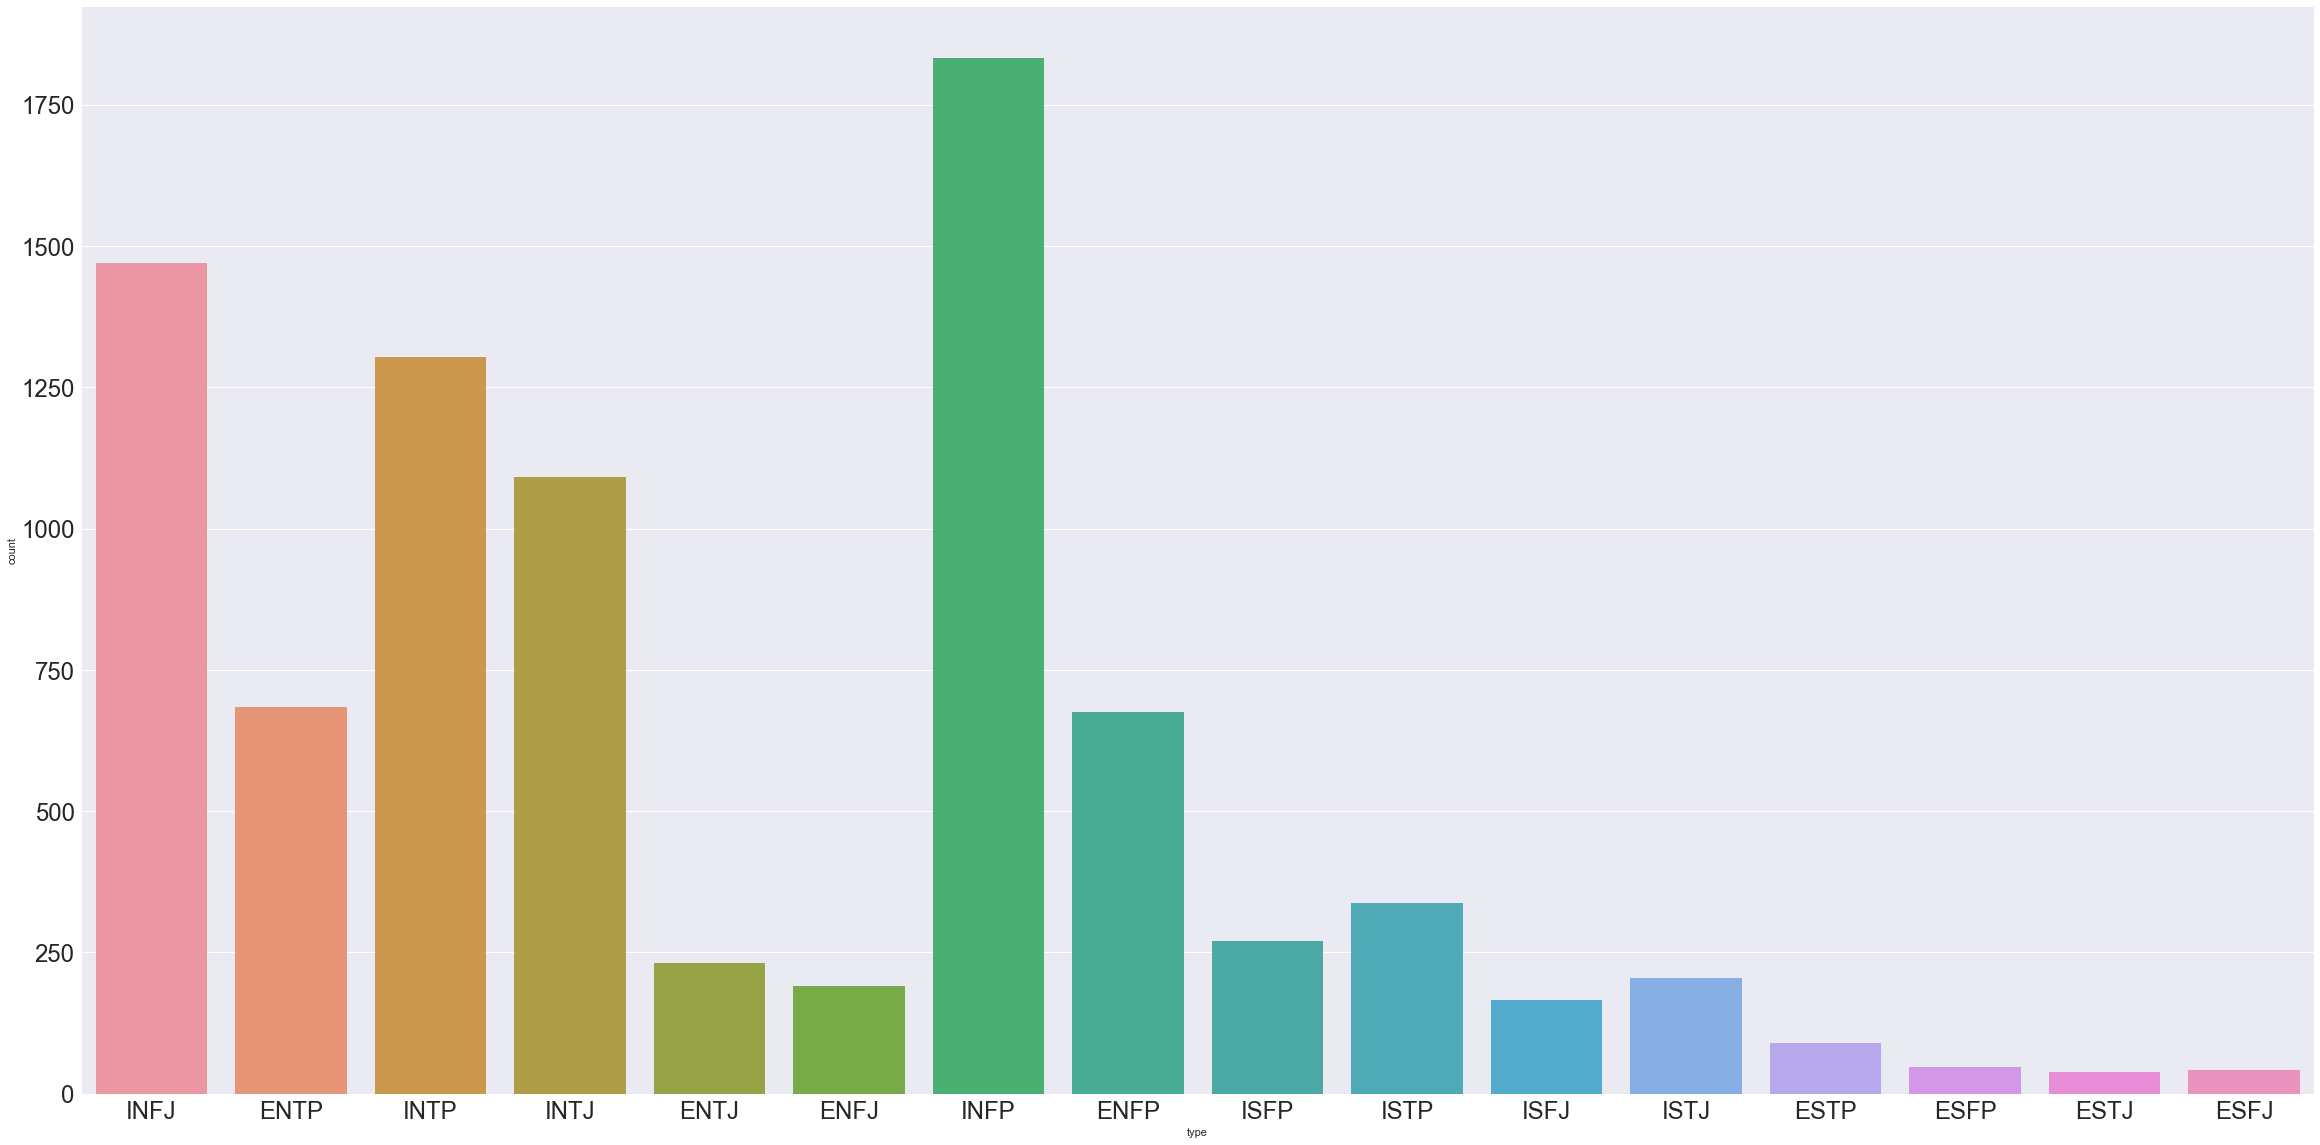

In [47]:
plt.figure(figsize=(40,20))
plt.xticks(fontsize=24, rotation=0)
plt.yticks(fontsize=24, rotation=0)
sns.countplot(data=data, x='type')

### It is clearly unbalanced throughout the different classes. 

# Preprocessing

In [48]:
##### Encode each type to an int

from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)


array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'], dtype=object)

In [103]:
##### Compute list of subject with Type | list of comments | list of url

list_subject = []

for row in data.iterrows():
    list_comment = []
    list_url = []
    posts = row[1].posts
    for post in posts.split("|||"):
        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', post)
        if urls:
            post = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', post)
            list_url += urls
        if any(post):
            list_comment.append(post)
    
    type_labelized = lab_encoder.transform([row[1].type])[0]
    list_subject.append([type_labelized, list_comment, list_url])

del data
subject_type = np.array([subject[0] for subject in list_subject])
#subject_comments = ["".join(subject[1]) for subject in list_subject]

<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence \(
<input>:10: DeprecationWarning: invalid escape sequence \(
<input>:12: DeprecationWarning: invalid escape sequence 

#### Exemple of one row

In [104]:
list_subject[0]

[8,
 ["'",
  'enfp and intj moments    sportscenter not top ten plays    pranks',
  'What has been the most life-changing experience in your life?',
  '     On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   ',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390     ...',
  'Welcome and stuff.',
  '  Game. Set. Match.',
  "Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...",
  "Basically come up with three items you've determined that each type (or whichever types you want to do) would more than likely use, given each types' cognitive fun

In [105]:
##### Remove and clean comments

from nltk import word_tokenize
#X = [word_tokenize("".join(subject[1])) for subject in list_subject]

# Remove numbers
subject_comments_1 = [re.sub("[^a-zA-Z]", " ", " ".join(sentence[1])).split(' ') for sentence in list_subject]

# Remove spaces
subject_comments_1 = [re.sub(' +', ' ', " ".join(comments)) for comments in subject_comments_1]

In [23]:
# Remove stopwords

from nltk.corpus import stopwords 

# subject_comments_1 = [" ".join([w for w in comment.split(' ') if w not in stopwords.words("english")]) for comment in subject_comments_1]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, analyzer='word', max_features=100,
                             min_df=3,
                             use_idf=True)

X_tfidf =  vectorizer.fit_transform(subject_comments_1).todense()
pickle
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 1500) 

X_vectorized = vectorizer.fit_transform(subject_comments_1).toarray()

X_concat = np.column_stack((X_tfidf, X_vectorized))

In [77]:
# Confusion plot
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [82]:
##### Multinomial Naive Bayes

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

def train_stratified(model, X, y, nsplits=3):
    '''
    Take a sklearn model like, feature set X, target set y and number of splits to compute Stratified kfold validation.
    '''
    for train, test in StratifiedKFold(subject_type, shuffle=True):
        model.fit(X[train], y[train])
        preds = model.predict(X[test])
        print(classification_report(y[test], preds))
            
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y[test], preds)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                              title='Normalized confusion matrix')

             precision    recall  f1-score   support

          0       0.30      0.44      0.36        64
          1       0.50      0.55      0.52       225
          2       0.23      0.44      0.30        77
          3       0.60      0.56      0.58       229
          4       0.04      0.07      0.05        14
          5       0.00      0.00      0.00        16
          6       0.00      0.00      0.00        13
          7       0.24      0.30      0.27        30
          8       0.68      0.47      0.55       490
          9       0.58      0.62      0.60       611
         10       0.63      0.54      0.58       364
         11       0.63      0.63      0.63       435
         12       0.53      0.34      0.41        56
         13       0.35      0.42      0.38        91
         14       0.38      0.43      0.41        69
         15       0.47      0.55      0.50       113

avg / total       0.56      0.53      0.54      2897

Normalized confusion matrix
             pr

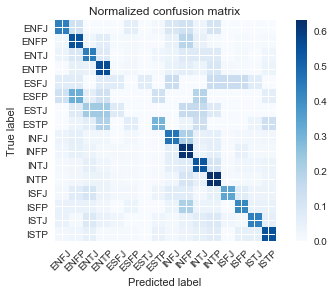

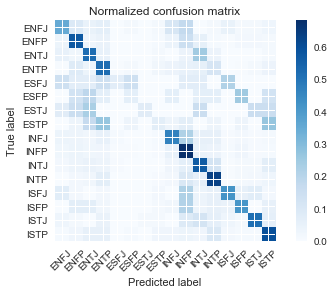

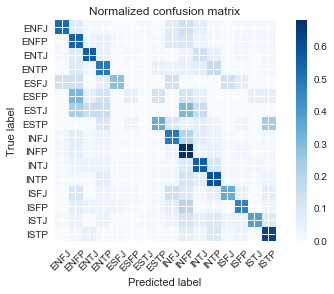

In [83]:
train_stratified(MultinomialNB(), X_concat, subject_type, 5)

[0]	train-merror:0.379403	test-merror:0.426267
[1]	train-merror:0.351608	test-merror:0.396313
[2]	train-merror:0.338158	test-merror:0.383641
[3]	train-merror:0.332138	test-merror:0.375576
[4]	train-merror:0.32458	test-merror:0.376728
[5]	train-merror:0.319329	test-merror:0.37212
[6]	train-merror:0.311771	test-merror:0.373272
[7]	train-merror:0.306136	test-merror:0.362903
[8]	train-merror:0.301396	test-merror:0.360599
[9]	train-merror:0.295632	test-merror:0.360599
[10]	train-merror:0.291533	test-merror:0.367512
[11]	train-merror:0.285769	test-merror:0.359447
[12]	train-merror:0.280646	test-merror:0.359447
[13]	train-merror:0.274369	test-merror:0.359447
[14]	train-merror:0.270526	test-merror:0.357143
             precision    recall  f1-score   support

          0       0.62      0.53      0.57        19
          1       0.67      0.72      0.70        68
          2       0.60      0.26      0.36        23
          3       0.60      0.49      0.54        69
          4       1.00    

/Users/Dupi/venv_py_3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1134: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0]	train-merror:0.375945	test-merror:0.404378
[1]	train-merror:0.352376	test-merror:0.376728
[2]	train-merror:0.341488	test-merror:0.358295
[3]	train-merror:0.332906	test-merror:0.367512
[4]	train-merror:0.326886	test-merror:0.355991
[5]	train-merror:0.321378	test-merror:0.353687
[6]	train-merror:0.31318	test-merror:0.345622
[7]	train-merror:0.308313	test-merror:0.342166
[8]	train-merror:0.300884	test-merror:0.337558
[9]	train-merror:0.294735	test-merror:0.336406
[10]	train-merror:0.288075	test-merror:0.332949
[11]	train-merror:0.282567	test-merror:0.329493
[12]	train-merror:0.277571	test-merror:0.329493
[13]	train-merror:0.274497	test-merror:0.326037
[14]	train-merror:0.264378	test-merror:0.322581
             precision    recall  f1-score   support

          0       0.62      0.42      0.50        19
          1       0.71      0.65      0.68        68
          2       0.56      0.39      0.46        23
          3       0.69      0.61      0.65        69
          4       1.00   

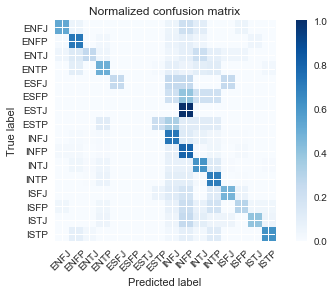

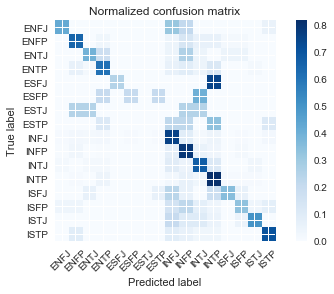

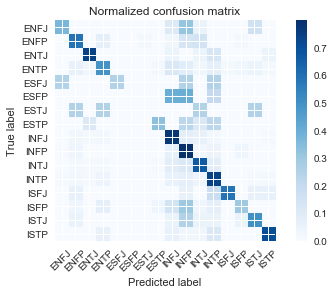

In [97]:
##### Extreme Gradient Boosting

import xgboost as xgb

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.6
param['ntrees'] = 300
param['subsample'] = 0.93
param['max_depth'] = 2
param['silent'] = 1
param['nthread'] = 8
param['num_class'] = len(unique_type_list)

def train_stratified_xgb(X, y, nsplits):
    '''
    Stratified kfold validation for xgboost.
    '''
    for train, test in StratifiedShuffleSplit(subject_type, nsplits):
        train_X, train_Y, test_X, test_Y = X[train], y[train], X[test], y[test]
        xg_train = xgb.DMatrix(train_X, label=train_Y)
        xg_test = xgb.DMatrix(test_X, label=test_Y)
        watchlist = [(xg_train, 'train'), (xg_test, 'test')]
        num_round = 15
        bst = xgb.train(param, xg_train, num_round, watchlist)
        preds = bst.predict(xg_test)
        print(classification_report(y[test], preds))
        # get prediction
        error_rate = np.sum(preds != test_Y) / test_Y.shape[0]
        print('Test error using softmax = {}'.format(error_rate))
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(test_Y, preds)
        np.set_printoptions(precision=2)

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=lab_encoder.inverse_transform(range(16)), normalize=True,
                              title='Normalized confusion matrix')

train_stratified_xgb(X_concat, subject_type, 3)

In [101]:
# Save model for later use

import pickle

X, y, nsplits = X_concat, subject_type, 1
for train, test in StratifiedShuffleSplit(y, nsplits):
    train_X, train_Y, test_X, test_Y = X[train], y[train], X[test], y[test]
    xg_train = xgb.DMatrix(train_X, label=train_Y)
    xg_test = xgb.DMatrix(test_X, label=test_Y)
    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 15
    bst = xgb.train(param, xg_train, num_round, watchlist)
    preds = bst.predict(xg_test)
    print(classification_report(y[test], preds))
    # get prediction
    error_rate = np.sum(preds != test_Y) / test_Y.shape[0]
    print('Test error using softmax = {}'.format(error_rate))
        
# save model to file
pickle.dump(bst, open("model.pickle.dat", "wb"))

[0]	train-merror:0.38363	test-merror:0.389401
[1]	train-merror:0.356091	test-merror:0.37212
[2]	train-merror:0.339695	test-merror:0.357143
[3]	train-merror:0.333547	test-merror:0.359447
[4]	train-merror:0.328423	test-merror:0.355991
[5]	train-merror:0.322147	test-merror:0.355991
[6]	train-merror:0.314718	test-merror:0.351382
[7]	train-merror:0.308697	test-merror:0.351382
[8]	train-merror:0.300243	test-merror:0.349078
[9]	train-merror:0.294479	test-merror:0.349078
[10]	train-merror:0.288843	test-merror:0.349078
[11]	train-merror:0.279877	test-merror:0.349078
[12]	train-merror:0.276675	test-merror:0.339862
[13]	train-merror:0.271423	test-merror:0.33871
[14]	train-merror:0.268349	test-merror:0.336406
             precision    recall  f1-score   support

          0       0.57      0.42      0.48        19
          1       0.63      0.62      0.62        68
          2       0.47      0.35      0.40        23
          3       0.67      0.70      0.68        69
          4       1.00     

/Users/Dupi/venv_py_3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1134: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/Dupi/venv_py_3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1134: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.57      0.42      0.48        19
          1       0.63      0.62      0.62        68
          2       0.47      0.35      0.40        23
          3       0.67      0.70      0.68        69
          4       1.00      0.25      0.40         4
          5       0.00      0.00      0.00         5
          6       0.00      0.00      0.00         4
          7       0.38      0.33      0.35         9
          8       0.65      0.69      0.67       147
          9       0.71      0.76      0.73       183
         10       0.67      0.63      0.65       109
         11       0.70      0.79      0.74       130
         12       0.57      0.47      0.52        17
         13       0.70      0.52      0.60        27
         14       0.44      0.40      0.42        20
         15       0.79      0.68      0.73        34

avg / total       0.66      0.66      0.66       868

Test error using softmax = 0.33640552995391

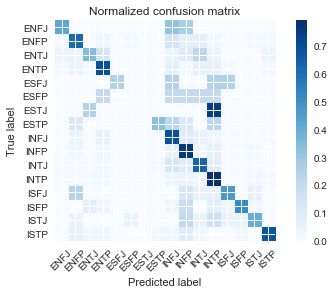